# Model Definition and Evaluation
## Table of Contents
1. [Model Selection](#model-selection)
2. [Feature Engineering](#feature-engineering)
3. [Hyperparameter Tuning](#hyperparameter-tuning)
4. [Implementation](#implementation)
5. [Evaluation Metrics](#evaluation-metrics)
6. [Comparative Analysis](#comparative-analysis)


In [209]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [210]:
# !pip install keras-tuner --upgrade

In [256]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.utils import compute_class_weight
from keras.optimizers import Adam
from keras_tuner.tuners import RandomSearch


## Model Selection

**Imbalanced dataset:** A significant disparity between normal and fraud cases (1 million vs. 200).

**Previous model performance:** VAE struggled with detecting fraud cases and had a high false positive rate.

**Data preprocessing:** SMOTE oversampling was applied to address the imbalance.

**Classification:** Sigmoid function was used for output.



### Model Selection for Fraud Detection
Given the imbalanced nature of the dataset and the challenges faced by the VAE model, we should prioritize models that can handle class imbalance effectively and have strong performance in anomaly detection or classification tasks.


## Feature Engineering

### Understanding the Baseline:

In enhancing the baseline model for fraud detection, several additional feature engineering steps were performed. These steps include generating customer profiling data from Call Detail Records (CDRs), oversampling using SMOTE, and scaling the data using StandardScaler.



In [212]:
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/datasets/filtered_data.csv')

In [213]:
df.drop(['Unnamed: 0', 'predicted_fraud'], axis=1, inplace=True)

In [214]:
X = df.drop('is_fraud', axis=1)
y = df['is_fraud']

In [215]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [216]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [217]:
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

In [218]:
X_train, y_train = pipeline.fit_resample(X_train, y_train)

In [219]:
counter = Counter(y_train)
print(counter)

Counter({0: 159840, 1: 79920})


## Hyperparameter Tuning

In the process of refining the fraud detection model, hyperparameter tuning was conducted using the Keras Tuner's RandomSearch method. Here’s a discussion of this approach and the rationale behind it:


**Hyperparameter Tuning with Random Search**

**Method:** Keras Tuner's RandomSearch

**Hyperparameters Tuned:**

**units:** Number of neurons in the layers.

**l2_regularizer:** Regularization parameter to prevent overfitting.

**dropout:** Dropout rate to prevent overfitting.

**learning_rate:** Learning rate for the optimizer.


In [220]:
# Implement hyperparameter tuning
def build_model(hp):
  model = Sequential()
  model.add(Dense(units=hp.Int('units', min_value=32, max_value=512, step=32), activation='relu', input_dim=X_train.shape[1], kernel_regularizer=l2(hp.Float('l2_regularizer', min_value=1e-4, max_value=1e-2, sampling='log'))))
  model.add(Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
  model.add(Dense(units=hp.Int('units', min_value=32, max_value=512, step=32), activation='relu', kernel_regularizer=l2(hp.Float('l2_regularizer', min_value=1e-4, max_value=1e-2, sampling='log'))))
  model.add(Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
  model.add(Dense(units=hp.Int('units', min_value=32, max_value=512, step=32), activation='relu', kernel_regularizer=l2(hp.Float('l2_regularizer', min_value=1e-4, max_value=1e-2, sampling='log'))))
  model.add(Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
  model.add(Dense(units=hp.Int('units', min_value=32, max_value=512, step=32), activation='relu', kernel_regularizer=l2(hp.Float('l2_regularizer', min_value=1e-4, max_value=1e-2, sampling='log'))))
  model.add(Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
  model.add(Dense(1, activation='sigmoid'))

  learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  optimizer = Adam(learning_rate=learning_rate)
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

  return model

In [221]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # Adjust the number of trials as needed
    executions_per_trial=3,  # Number of times to run each trial
    directory='my_dir',
    project_name='my_project'
)

Reloading Tuner from my_dir/my_project/tuner0.json


In [222]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
tuner.search(X_train, y_train, epochs=20, validation_split=0.2, callbacks=[early_stop], class_weight=class_weights)

In [228]:
best_hyperparameters = tuner.get_best_hyperparameters()[0]
print(best_hyperparameters.values)

{'units': 96, 'l2_regularizer': 0.0001273278728998373, 'dropout': 0.2, 'learning_rate': 0.001}


In [226]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 96)                  │           2,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 96)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 96)                  │           9,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 96)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 96)                  │           9,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 96)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 96)                  │           9,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 96)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              97 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,433 (118.88 KB)

 Trainable params: 30,433 (118.88 KB)

 Non-trainable params: 0 (0.00 B)

## Implementation

Best Parameters we find after hyperparemeter tuning are:

**units**: 96

**l2_regularizer**: 0.0001273278728998373

**dropout**: 0.2

**learning_rate**: 0.001


In [249]:
# Implement the final model(s)
model = Sequential()
model.add(Dense(96, activation='relu', input_dim=X_train.shape[1], kernel_regularizer=l2(0.0001273278728998373)))
model.add(Dropout(0.2))
model.add(Dense(96, activation='relu', kernel_regularizer=l2(0.0001273278728998373)))
model.add(Dropout(0.2))
model.add(Dense(96, activation='relu', kernel_regularizer=l2(0.0001273278728998373)))
model.add(Dropout(0.2))
model.add(Dense(96, activation='relu', kernel_regularizer=l2(0.0001273278728998373)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [250]:
# Compile the model
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [251]:
# Train the model
early_stop = EarlyStopping(monitor='val_loss', patience=5)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
history = model.fit(X_train, y_train, epochs=3, validation_split=0.2, callbacks=[early_stop], class_weight=class_weights)

Epoch 1/3
5994/5994 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.9388 - loss: 0.2043 - val_accuracy: 0.8603 - val_loss: 0.3115
Epoch 2/3
5994/5994 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - accuracy: 0.9676 - loss: 0.1146 - val_accuracy: 0.9396 - val_loss: 0.1701
Epoch 3/3
5994/5994 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9702 - loss: 0.1060 - val_accuracy: 0.9382 - val_loss: 0.1426


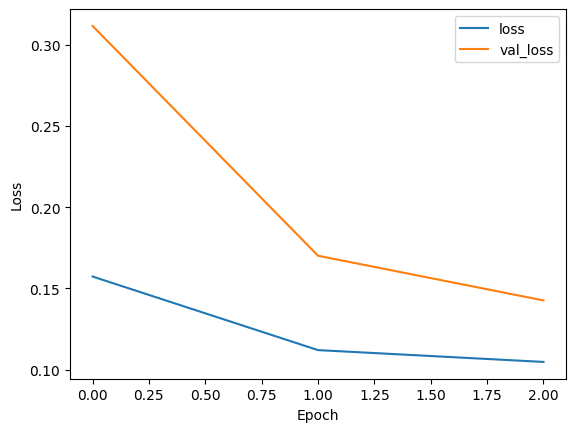

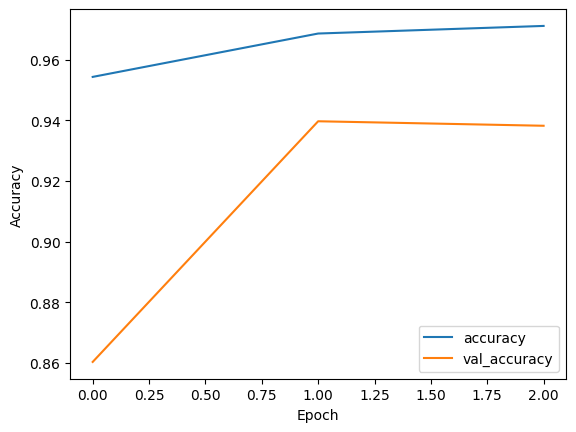

In [252]:
# Plot training history
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Evaluation Metrics

For evaluating the performance of the fraud detection model, the F1 score was chosen as the primary metric. Here’s a detailed explanation of the metrics used and the rationale behind choosing them:


**Primary Metric:** F1 Score

**Description:** The F1 score is the harmonic mean of Precision and Recall.

**Rationale:**

**Class Imbalance:** In fraud detection, the dataset is highly imbalanced, with a very small number of fraud cases compared to non-fraud cases. The F1 score is particularly useful in this scenario as it balances both precision and recall, providing a single metric that considers both false positives and false negatives.


In [253]:
y_pred = best_model.predict(X_test)

6245/6245 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


In [257]:
# Evaluate the model using your chosen metrics
y_pred_classes = (y_pred > 0.5).astype(int)

print(confusion_matrix(y_test, y_pred_classes))
print(classification_report(y_test, y_pred_classes))


[[197175   2627]
 [    10     27]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    199802
           1       0.01      0.73      0.02        37

    accuracy                           0.99    199839
   macro avg       0.51      0.86      0.51    199839
weighted avg       1.00      0.99      0.99    199839



In [258]:
cm = confusion_matrix(y_test, y_pred_classes)

In [259]:
# Create pandas DataFrame from confusion matrix
cm_df = pd.DataFrame(cm, index=[0,1], columns=[0,1])

# Print or display the confusion matrix DataFrame
print(cm_df)

# Generate classification report
report = classification_report(y_test, y_pred_classes, output_dict=True)
# Print classification report in a more readable format (optional)
print(pd.DataFrame(report).transpose())

        0     1
0  197175  2627
1      10    27
              precision    recall  f1-score        support
0              0.999949  0.986852  0.993357  199802.000000
1              0.010173  0.729730  0.020067      37.000000
accuracy       0.986804  0.986804  0.986804       0.986804
macro avg      0.505061  0.858291  0.506712  199839.000000
weighted avg   0.999766  0.986804  0.993177  199839.000000


In [260]:
f1_score(y_test, y_pred_classes)

0.020066889632107024

## Comparative Analysis

The improved model, using customer profiling data, SMOTE, StandardScaler, and RandomSearch, increased the F1 score compared to the baseline VAE model. However, further improvements are needed, potentially by transforming the training data to enhance performance.


In [261]:
# Comparative Analysis code (if applicable)
# Example: comparing accuracy of the baseline model and the new model
baseline_f1 = '0.004407173899736793'
vae_f1 = '0.0033641715727502105'
smote_f1 = '0.020066889632107024'
print(f"Baseline Model F1-Score: {baseline_f1}, VAE Model F1-Score: {vae_f1}, SMOTE sigmoid Model F1-Score: {smote_f1}")


Baseline Model F1-Score: 0.004407173899736793, VAE Model F1-Score: 0.0033641715727502105, SMOTE sigmoid Model F1-Score: 0.020066889632107024
